# IBM Applied Data Science Project Coursera Capstone
# Potential Places to Establish Hospitals in Singapore
### By: Vincentius Indra Sulaiman

## Import Section

In [2]:
#Install Required Packages
!pip install beautifulsoup4
!easy_install lxml
!pip install geocoder
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge folium=0.5.0 --yes
!pip install yellowbrick
print('Installation successful')

     |████████████████████████████████| 112kB 4.1MB/s eta 0:00:01
Searching for lxml
Reading https://pypi.org/simple/lxml/
Best match: lxml 4.5.0
Processing lxml-4.5.0-cp36-cp36m-manylinux1_x86_64.whl
Installing lxml-4.5.0-cp36-cp36m-manylinux1_x86_64.whl to /home/jupyterlab/conda/envs/python/lib/python3.6/site-packages
writing requirements to /home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/lxml-4.5.0-py3.6-linux-x86_64.egg/EGG-INFO/requires.txt
Adding lxml 4.5.0 to easy-install.pth file

Installed /home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/lxml-4.5.0-py3.6-linux-x86_64.egg
Processing dependencies for lxml
Finished processing dependencies for lxml
     |████████████████████████████████| 102kB 16.8MB/s ta 0:00:01
     |████████████████████████████████| 829kB 18.8MB/s eta 0:00:01
     |████████████████████████████████| 81kB 15.1MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc

In [3]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json 
from geopy.geocoders import Nominatim
import geocoder 
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium # map rendering library
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer

print('Libraries imported successfully.')

Libraries imported successfully.


## Scraping Section to obtain dataframe

In [4]:
# We will scrape the wikipedia

url = 'https://en.wikipedia.org/wiki/New_towns_of_Singapore'
extraction = requests.get(url).text
wiki_data = BeautifulSoup(extraction, features='html')

In [54]:
column_names = ['Name', 'Chinese', 'Pinyin', 'Tamil', 'Total Area', 'Residential Area', 'Units', 'Ultimate', 'Population']
df_SG_original = pd.DataFrame(columns = column_names)

content = wiki_data.find('div', class_='mw-parser-output')
table = content.table.tbody
name = 0
chinese = 0
pinyin = 0
tamil = 0
total_area = 0
residential_area = 0
units = 0
ultimate = 0
population = 0

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            name = td.text.strip('\n')
            i = i + 1
        elif i == 1:
            chinese = td.text.strip('\n')
            i = i + 1
        elif i == 2:
            pinyin = td.text.strip('\n')
            i = i + 1
        elif i == 3:
            tamil = td.text.strip('\n')
            i = i + 1
        elif i == 4:
            total_area = td.text.strip('\n')
            i = i + 1
        elif i == 5:
            residential_area = td.text.strip('\n')
            i = i + 1
        elif i == 6:
            units = td.text.strip('\n')
            i = i + 1 
        elif i == 7:
            ultimate = td.text.strip('\n')
            i = i + 1
        elif i == 8:
            population = td.text.strip('\n')
    df_SG_original = df_SG_original.append({'Name': name,'Chinese': chinese, 'Pinyin': pinyin, 'Tamil':tamil, \
    'Total Area': total_area,'Residential Area': residential_area, 'Units': units, 'Ultimate': ultimate, \
    'Population': population},ignore_index=True)

#Copy the data from original df_SG
df_SG = df_SG_original.copy()

#Cleaning Service that removes unnecessary row and columns
df_SG.drop(df_SG.index[0], inplace=True)
df_SG.drop({'Chinese', 'Pinyin', 'Tamil', 'Units', 'Ultimate'}, axis=1,inplace = True)
df_SG.reset_index(inplace=True, drop=True)

## Coordinate Data Collection Section

In [55]:
#Defining function to obtain coordinate data using geocoder
def get_latlng(Name):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, KSingapore'.format(Name))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [56]:
#Obtaining coordinate data
coordinates = [get_latlng(Name) for Name in df_SG['Name'].tolist()]
df_coordinates = pd.DataFrame(coordinates, columns=['Latitude', 'Longitude'])

In [59]:
#Appending coordinate data to our dataframe
df_SG['Latitude'] = df_coordinates['Latitude']
df_SG['Longitude'] = df_coordinates['Longitude']
df_SG.head()

,Name,Total Area,Residential Area,Population,Latitude,Longitude
0,Ang Mo Kio,6.38,2.83,"149,800",1.37161,103.84546
1,Bedok,9.37,4.18,"204,300",1.32425,103.95297
2,Bishan,6.90,1.72,"65,700",1.35079,103.85110
3,Bukit Batok,7.85,2.91,"113,800",1.34952,103.75277
4,Bukit Merah,8.58,3.12,"147,000",1.28322,103.81676


In [60]:
#Saving as CSV file
df_SG.to_csv('df_SG.csv', index=False)

## Applying some arithmetical operation to obtain population density

In [61]:
df_SG2 = pd.read_csv('df_SG.csv')
df_SG3 = pd.read_csv('df_SG.csv')
df_SG2.rename(columns={'Residential Area' : 'Residential_Area'}, inplace=True)
df_SG2['Population'] = df_SG2['Population'].apply(lambda x: x.replace(',','.'))
df_SG2 = df_SG2.iloc[:, 1:].astype(float)
df_SG2['Population Density'] = df_SG2.Population / df_SG2.Residential_Area
df_SG2['Name'] = df_SG3['Name']
fixed_columns = [df_SG2.columns[-1]] + list(df_SG2.columns[:-1])
df_SG2 = df_SG2[fixed_columns]
df_SG2.head()

,Name,Total Area,Residential_Area,Population,Latitude,Longitude,Population Density
0,Ang Mo Kio,6.38,2.83,149.8,1.37161,103.84546,52.932862
1,Bedok,9.37,4.18,204.3,1.32425,103.95297,48.875598
2,Bishan,6.90,1.72,65.7,1.35079,103.85110,38.197674
3,Bukit Batok,7.85,2.91,113.8,1.34952,103.75277,39.106529
4,Bukit Merah,8.58,3.12,147.0,1.28322,103.81676,47.115385


## Folium Section : MAPS

In [62]:
# Obtain Singapore Coordinates
df_SG4 = df_SG2
country = 'Singapore'

geolocator = Nominatim(user_agent='HeySingapore')
location = geolocator.geocode(country)
latitude = location.latitude
longitude = location.longitude
print('The coordinates of Singapore are {}, {}.'.format(latitude, longitude))

The coordinates of Singapore are 1.357107, 103.8194992.


In [63]:
#Let us create Singapore Maps
map_SG = folium.Map(location=[latitude, longitude], zoom_start=11)

#Add markers to Singapore map
for lat, lng, name in zip(df_SG4['Latitude'], df_SG4['Longitude'], df_SG4['Name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_SG)  
map_SG

In [64]:
#Save The Map
map_SG.save('map_SG.html')

## Foursquare Section

In [65]:
#Initialising Foursquare Credentials
CLIENT_ID = 'LE3EDX02I5LDJAKS5UI4SR1IT5CO1MKLAX3TTCI53VSYGEMY'
CLIENT_SECRET = 'PCM4W5RJF0H4FXFM4LGUUVGROTVUDDGM3SAI4MI3ALRLELEB'
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
limit = 60

Your credentials:
CLIENT_ID: LE3EDX02I5LDJAKS5UI4SR1IT5CO1MKLAX3TTCI53VSYGEMY
CLIENT_SECRET:PCM4W5RJF0H4FXFM4LGUUVGROTVUDDGM3SAI4MI3ALRLELEB


In [66]:
#Defining Function to retrieve venues in the vicinity
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&categoryId=58daa1558bbb0b01f18ec1f7&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()['response']['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],
            v['categories'][0]['name']) for v in results])
            
     
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Name', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category']
    
    return(nearby_venues)

In [67]:
SG_venues3 = getNearbyVenues(names=df_SG4['Name'],
                                   latitudes=df_SG4['Latitude'],
                                   longitudes=df_SG4['Longitude']
                                  )

In [68]:
#Create a DataFrame to count hospital wards
venues_df = pd.DataFrame(SG_venues3)

# Define column names
venues_df.columns = ['Name', 'Latitude', 'Longitude', 'Venue_Name', 'Venue_Latitude', 'Venue_Longitude', 'Venue_Category']

print(venues_df.shape)

#Save SG_Venues to CSV file
SG_venues3.to_csv('SG_venues3.csv')

(161, 7)


In [69]:
#Merging our hospital ward count dataframe with previous df_SG2 dataframe that contains population density
#The new df_merged database will be used for clustering the neighborhoods
#Note that Name columns means Town Name
#For towns that do not have hospital ward, ward count is assigned zero (0) with fillna function 
df_to_merge = pd.DataFrame(venues_df.groupby(['Name']).count().iloc[:,2]).reset_index()
df_to_merge.rename(columns={'Venue_Name':'Ward Count'}, inplace=True)
df_merged = df_SG2.merge(df_to_merge, on='Name', how='left').fillna(0)
df_merged.to_csv('df_merged.csv', index = False)

## Clustering Section

In [70]:
df_cluster = pd.read_csv('df_merged.csv')
df_cluster.drop({'Total Area', 'Residential_Area', 'Population', 'Latitude', 'Longitude'}, axis=1,inplace = True)
df_cluster.head()

,Name,Population Density,Ward Count
0,Ang Mo Kio,52.932862,0.0
1,Bedok,48.875598,8.0
2,Bishan,38.197674,6.0
3,Bukit Batok,39.106529,8.0
4,Bukit Merah,47.115385,26.0


### Now, we will scale the dataframe for clustering with minmax scaler function from sklearn

In [71]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_cluster.iloc[:,1:]))
df_scaled.rename(columns={0:'S_Population_Density', 1:'S_Ward_Count'}, inplace=True)
df_scaled['Name'] = df_cluster['Name']
fixed_columns4 = [df_scaled.columns[-1]] + list(df_scaled.columns[:-1])
df_scaled = df_scaled[fixed_columns4]
df_scaled.head()

,Name,S_Population_Density,S_Ward_Count
0,Ang Mo Kio,0.953049,0.000000
1,Bedok,0.829516,0.163265
2,Bishan,0.504400,0.122449
3,Bukit Batok,0.532073,0.163265
4,Bukit Merah,0.775922,0.530612


## Try to Cluster Neighborhoods

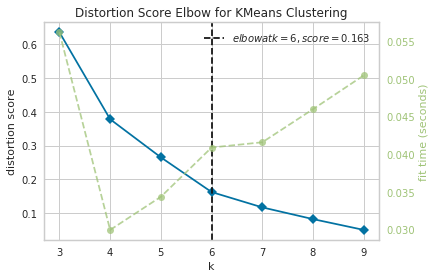

In [72]:
df_SG5 = df_SG2.copy()
df_clustered = df_scaled.drop('Name', 1)

# Instantiate the clustering model and visualizer
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(3,10))
visualizer.fit(df_clustered)       
visualizer.show()  

In [73]:
#Determine number of clusters
#According to yellowbrick visualiser, optimal cluster number = 6
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_clustered)
#Add Cluster Labels back to dataframe
df_SG5.insert(7, 'Cluster Labels', kmeans.labels_)
df_SG5.dropna(inplace=True)
df_SG5 = df_SG5.merge(df_scaled, on = 'Name', how = 'left').fillna(0)
#df_SG5.drop({2}, axis=1, inplace=True)
df_SG5.head()

,Name,Total Area,Residential_Area,Population,Latitude,Longitude,Population Density,Cluster Labels,S_Population_Density,S_Ward_Count
0,Ang Mo Kio,6.38,2.83,149.8,1.37161,103.84546,52.932862,3,0.953049,0.000000
1,Bedok,9.37,4.18,204.3,1.32425,103.95297,48.875598,1,0.829516,0.163265
2,Bishan,6.90,1.72,65.7,1.35079,103.85110,38.197674,4,0.504400,0.122449
3,Bukit Batok,7.85,2.91,113.8,1.34952,103.75277,39.106529,4,0.532073,0.163265
4,Bukit Merah,8.58,3.12,147.0,1.28322,103.81676,47.115385,5,0.775922,0.530612


In [157]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11, tiles='Stamen Terrain')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_SG5['Latitude'], df_SG5['Longitude'], df_SG5['Name'], df_SG5['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        na=True,
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

### Legends  
Cluster 0: Red   
Cluster 1: Violet   
Cluster 2: Blue   
Cluster 3: Turquoise   
Cluster 4: Pale Green   
Cluster 5: Orange  

In [133]:
#Save The Cluster Map
map_clusters.save('map_clusters.html')

## Summarising the mean results of each cluster

In [104]:
df_SG7 = df_SG5.groupby('Cluster Labels').mean()
df_SG8 = df_SG7.iloc[:, [6,7]].sort_values("S_Population_Density", ascending=False)
df_SG8

,S_Population_Density,S_Ward_Count
Cluster Labels,,
3,0.953241,0.000000
5,0.823461,0.642857
1,0.755956,0.058673
0,0.661177,1.000000
4,0.480231,0.093878
2,0.075705,0.030612


## Data Analysis  
It can be inferred from the table above that:     
Cluster 0: medium-high population density, highest hospital ward count    
Cluster 1: high population density, very low hospital ward count    
Cluster 2: lowest population density, very low hospital ward count    
Cluster 3: highest population density, no hospital ward count   
Cluster 4: medium population density, low hospital ward count  
Cluster 5: high population density, moderate ward count  

Therefore, we can summarise the results as priorities to develop each cluster as follows:  
High priority clusters: 3, 1   
Medium priority clusters: 4   
Low priority clusters: 5, 2     
Zero priority clusters: 0    
   
High Priority Clusters 3 and 1   
Towns     
--- 3: Ang Mo Kio, Bukit Panjang, Choa Chu Kang, Jurong West, Woodlands     
--- 1: Bedok, Geylang, Hougang, Jurong East, Sengkang, Serangoon, Tampines, Yishun  
   
Medium Priority Cluster 4   
Towns   
--- 4: Bishan, Bukit Batok, Clementi, Pasir Ris, Queenstown   
    
Low Priority Clusters 5 and 2   
Towns    
--- 5: Bukit Merah, Kallang/Whampoa  
--- 2: Punggol, Sembawang     
     
Zero Priority Cluster 0     
Towns     
--- 0: Toa Payoh   

## Cluster 0

In [77]:
df_SG6 = df_SG5[df_SG5['Cluster Labels'] == 0]
df_SG6.iloc[:, [0,8,9]]

,Name,S_Population_Density,S_Ward_Count
20,Toa Payoh,0.661177,1.0


## Cluster 1

In [78]:
df_SG6 = df_SG5[df_SG5['Cluster Labels'] == 1]
df_SG6.iloc[:, [0,8,9]]

,Name,S_Population_Density,S_Ward_Count
1,Bedok,0.829516,0.163265
8,Geylang,0.648912,0.000000
9,Hougang,0.833055,0.000000
10,Jurong East,0.823154,0.163265
17,Sengkang,0.771718,0.061224
18,Serangoon,0.704976,0.000000
19,Tampines,0.667423,0.020408
22,Yishun,0.768890,0.061224


## Cluster 2

In [79]:
df_SG6 = df_SG5[df_SG5['Cluster Labels'] == 2]
df_SG6.iloc[:, [0,8,9]]

,Name,S_Population_Density,S_Ward_Count
14,Punggol,0.151411,0.061224
16,Sembawang,0.000000,0.000000


## Cluster 3

In [80]:
df_SG6 = df_SG5[df_SG5['Cluster Labels'] == 3]
df_SG6.iloc[:, [0,8,9]]

,Name,S_Population_Density,S_Ward_Count
0,Ang Mo Kio,0.953049,0.0
5,Bukit Panjang,1.000000,0.0
6,Choa Chu Kang,0.939126,0.0
11,Jurong West,0.990616,0.0
21,Woodlands,0.883415,0.0


## Cluster 4


In [81]:
df_SG6 = df_SG5[df_SG5['Cluster Labels'] == 4]
df_SG6.iloc[:, [0,8,9]]

,Name,S_Population_Density,S_Ward_Count
2,Bishan,0.504400,0.122449
3,Bukit Batok,0.532073,0.163265
7,Clementi,0.428787,0.000000
13,Pasir Ris,0.404167,0.020408
15,Queenstown,0.531729,0.163265


## Cluster 5

In [82]:
df_SG6 = df_SG5[df_SG5['Cluster Labels'] == 5]
df_SG6.iloc[:, [0,8,9]]

,Name,S_Population_Density,S_Ward_Count
4,Bukit Merah,0.775922,0.530612
12,Kallang/Whampoa,0.871001,0.755102


## Further Investigation on Individual Towns

By investigating further on high priority clusters: cluster 3 and cluster 1   
It is found that certain towns provides even more surprising new facts.   
Those facts are reported as follows:     
1. Bukit Panjang has the highest population density across __Singapore__ but no hospital wards. 
1. Jurong West has the highest population density after Bukit Panjang in cluster 3 but no hospital wards.
1. All cluster 3 towns outclasses those of cluster 1 because all cluster 3 towns have higher density and no hospital ward count.
1. Hougang, Bedok, and Jurong East have the best potential from cluster 1 towns: the highest population density in cluster 1 but no hospital wards.

In order to provide preventive advices, we may also look on other lower priority clusters.   
Another new facts are also reported below:    
1. Toa Payoh has the highest hospital ward count across __Singapore__. Thus, the reader is advised to set it aside.
1. Sembawang has the lowest population density across __Singapore__, even though it has no hospital wards nearby. Thus, the reader is advised to set it aside. 

Furthermore, another interesting fact is found:  
1. Clementi and Pasir Ris has moderate population density but zero and very low hospital ward respectively .   
These two towns may be prioritised after considering the high priority areas from cluster 3 and 1 first.   

# End of Capstone Project
## Thank you very much.